In [106]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Loss functions

Every supervised learning algorithm is constructed as a ways to minimize some kind of **loss function**. Intuitively, the lower the loss, the better the algorithm has learned.

Data scientists are usually aware of the issue of overfitting: if you give your algorithm enough degrees of freedom, it will "memorize" the training data and achieve zero loss, but without being able to generalize to new data. Techniques such as regularization and dropoout are means to avoid overfitting; we won't discuss them in this session, and assume they are being taken care of.

Instead, we will focus on a more fundamental question: what is a good choice for a  loss function?

## Loss functions: executive summary
We start with the conclusions for the lazy reader:
* Simply using **log-loss with weights** is usually more than enough. This can be achieved via `class_weight` parameters in many standard algorithms, and worst-case scenario via `sample_weights` in the `.fit` method of all scikit-learn models.
* With tabular data, our experiments using focal loss did not outperform adding weights by a lot; if you have a ready-to-use implementation, it is however good to try 
* Log-loss seems to be good even in the case where we want high ROC AUC. It outperformed or was on par with AUC-specific optimizing methods

---

## Back to basics: the log-loss

In binary classification, the standard loss function is the **log-loss** (aka binary cross-entropy)

$$\boxed{\ell(y, q) = - y \log q - (1-y) \log(1-q)}$$

where $y$ is the real label taking values 0 or 1, and $q \in [0,1]$ is a predicted score, $q = q(x) = \widehat{\mathbb P}(Y=1|X=x)$. The logarithm is usually taken to be the natural log (base $e$), although any other base would be equally valid. We take $0 \log 0 \equiv 0$, as would be the natural extension from the limit.

> For example: if we predict a score of $q=0.8$ for a point with $y=1$, this yields a log-loss of $-\log 0.8 = 0.22$.

This function has a few key properties:
* It is zero when we yield a perfectly sure predictor: if $y=1$ and we predict $q=1$, the error is zero. Analogously for $y=0$ and $q=0$.
* It is non-negative: thus, a prediction can be more or less penalized, but there is always some level of penalty.
* **It diverges**: for $y=1$, it diverges at $q \to 0$ and analogously for $y=0$ it diverges at $q \to 1$. This is will be an important point of discussion in the following sections.

### Where does the log-loss come from? The Bernoulli formalism

Recall our probabilistic setup: we consider a pair of jointly distributed variables $(X,Y)$ where $Y$ takes values in $\{0,1\}$. This means that $\mathbb P(Y=1|X=x) \equiv q(x)$ is some function of $x$, and similarly $\mathbb P(Y=0|X=x) = 1 - \mathbb P(Y=1|X=x) = 1-q(x)$. 

We then say that the variable $Y|X=x$ is a **Bernoulli variable** with parameter $q(x)$, and write

$$\boxed{Y|X=x \; \sim \; \mathrm{Bernoulli}(q(x))}$$

The log-loss comes from the following result:

**Proposition**. Let there be $N$ iid random variables $Y_i \sim \mathrm{Bernoulli}(q)$, whose values we observe as $y_1,\ldots, y_N$. The maximum likelihood estimator $\hat q$ of $q$ is the one that maximizes the empirical likelihood function

$$L(q) =  \sum_{i=1}^N [y_i \log q + (1-y_i) \log (1-q)],$$

namely 

$$\hat q = \frac{1}{N} \sum_{i=1}^N y_i$$

*Proof*: notice that we can write the two expressions $\mathbb P(Y=1) =q $ and $\mathbb P(Y=0) = 1 - q$ concisely as 

$$\mathbb P(Y=y) = q^y (1-q)^{1-y}.$$

The joint probability of obtaining the observed values $y_1,\ldots, y_n$ is then 

$$\mathbb P(Y_1 = y_1,\ldots, Y_N = y_N) = \prod_{i=1}^N q^{y_i} (1-q)^{1-y_i}.$$

Taking the log of both sides yields the log-likelihood function,

$$L(q) = \log \prod_{i=1}^N q^{y_i} (1-q)^{1-y_i} = \sum_{i=1}^N [y_i \log q + (1-y_i) \log (1-q)]$$

Maximum likelihood estimation states that we want to find the $q$ value that maximizes this quantity. This is equivalent to minimizing its negative, which is exactly the log-loss, as we wanted to show. $\blacksquare$

## Why do we use the log-loss?

In most cases in binary classification, we use the log-loss as our loss function. Why?

It is a very natural choice. *Any* binary classification problem can be written as a ($x$-dependent) Bernoulli variable, ie. a Bernoulli problem where the parameter $q$ is a function $q(x)$.

Logistic regression, in particular, *explicitly* writes $q(x) \equiv q_\beta(x)$ as a sigmoid,

$$q_\beta(x) = \frac{1}{\displaystyle 1 + e^{-\beta \cdot x}}$$

and so allows us to run gradient descent on $\beta$ via explicit minimization of the log-loss.

## Are there other losses?

Absolutely. Any function which gives a positive number when the predicted score is "far" from the label and a small one otherwise is a valid loss. If this function is furthermore a differentiable function of the parameters, everything gets even better.

* **SVM example**: in linear support vector machines we minimize the **hinge loss**

    $$L_\mathrm{hinge} = \sum_{i=1}^N \max\{0, 1 - y_i (w\cdot x_i+b)\}$$

    where $w\in\mathbb R^n$, $b\in\mathbb R$ (and, here, $y_i \in \{-1, 1\}$). Notice that this is a completely different setup: instead of predicting a score $q$, we predict $ F(x_i) \equiv w \cdot x_i + b$ directly; if this quantity has the same sign as $y_i$, then their product is positive and the loss goes down, whereas if the signs are opposite this increases the loss.

* **AdaBoost**: in the AdaBoost algorithm, one often talks about the **exponential loss** 

  $$L_\mathrm{exp} = \frac{1}{N}\sum_{i=1}^N [y_i e^{-F(x_i)} + (1-y_i) e^{+F(x_i)}]$$
  
  where $F(x)$ is a transformed quantity, related to the predicted probability score (usually, we only take $\mathrm{sign}\;F(x)$ in the end as the predicted variable).
  
  Under the choice [1] of link function
  
  $$q(x) = \frac{1}{\displaystyle 1+e^{-2F(x)}} \quad \Leftrightarrow \quad F(x) = \frac 12 \log \frac{q}{1-q}$$
  
  we can rewrite the loss function as a function of $y$ and the score $q$, in an expression similar to the log-loss:
  
  $$\boxed{L_\mathrm{exp} = y \sqrt{\frac{1-q}{q}} + (1-y) \sqrt{\frac{q}{1-q}}.}$$

* **Brier score**: as we will see in the Calibration section, we can define the so-called Brier loss (or Brier score)
  
  $$\boxed{L_\mathrm{Brier} = (y-q)^2 = y(1-q)^2 + (1-y)q^2}$$
  
  
* **Focal loss**: for completeness, we write out here the focal loss, which we will discuss in the section about imbalanced learning:

  $$\boxed{L_\mathrm{focal} = -y (1-q)^\gamma \log q - (1-\eta) q^\gamma \log(1-q)}$$

---

# Advanced topic: proper scoring rules
(this section can be skipped on a first reading)

### Expected losses

All loss functions discussed above can be written in the form

$$\boxed{L(y|q) = y L_1(1-q) + (1-y)L_0(q)}.$$

Here, we have explicitly written that $L$ depends on $y$ *conditioned on* the predicted score $q$. Notice that this is the only dependence that $y$ has on $x$, namely via $q = q(x)$. 

> Example: for the log-loss, 
$$\begin{align*}
L_0(q) &= - \log(1-q)\\
L_1(1-q) &= -\log q \quad \Rightarrow L_1(u) = - \log(1-u) = L_0(u)
\end{align*}$$
Notice that both functions are equal, but functions of different variables.

> Example: for the Brier loss,
$$L_0(q) = q^2, \quad L_1(1-q) = (1-q)^2$$

In what follows, **we fix a point $X=x$**. Write $Y|X=x$ as simply $Y$ as an abuse of notation. Then, 

$$Y \sim \mathrm{Bernoulli}(\eta)$$

where $\eta = \mathbb P(Y=1)$ (really $\mathbb P(Y=1|X=x)$). 

We define the **expected loss**

$$\boxed{R(\eta|q) = \mathbb E_Y L(Y|q).}$$

It is a function of two variables: the real Bernoulli parameter $\eta$, and the predicted score $q$. 

Intuitively, what do we want? If we predict the parameter perfectly (ie. $q = \eta$) we would expect $R$ to be minimized. This is a logical desideratum, but it is not obvious, and it motivates the following:


### Proper scoring rules 
A loss function $L(y|q)$ is a **proper scoring rule** if the expected loss $q \mapsto R(\eta|q)$ is minimized by $q=\eta$. It is further described as **strict** if $\eta$ is the global minimizer.

> Notice that we can write, since $\mathbb E[Y] =\eta$ if $Y \sim \mathrm{Bernoulli}(\eta)$:
$$\boxed{R(\eta|q) = \eta L_1 (1-q) + (1-\eta) L_0(q)}$$

Not everything is a proper scoring rule. The losses we mentioned above definitely are, but ROC AUC or Average Precision, for instance, are not. In fact, proper scoring rules have very interesting properties, which we now lay out:

**Theorem** [Shuford-Albert-Massengil] 

$L(y|p)$ is a proper scoring rule if and only if there exists a **weight function** $\omega: [0,1] \to \mathbb R_+$ such that

$$\frac{d L_1(1-q)}{d(1-q)} = \omega(q) (1-q),\qquad \frac{d L_0}{dq} = \omega(q) q;$$

if these are bounded below, then the equations can be integrated to give

$$L_1(1-q) = \int_q^1 (1-c) \omega(c) dc,\qquad L_0(q) = \int_0^q c \omega(c) dc,$$

[and in fact, this is the general form regardless of smoothness, due to a theorem by Schervish 1989].  

In the case of twice-differentiable $R$, 

$$\boxed{\omega(\eta) = \left.\frac{\partial^2 R(\eta|q)}{\partial q^2} \right|_{q = \eta}}$$

> Example: consider again the log-loss, where $L(y|q) = - y \log q - (1-y) \log (1-q)$. The expected loss is
$$R(\eta|q) = -\mathbb E[y] \log q - (1-\mathbb E[y]) \log(1-q) = - \eta \log q - (1-\eta)\log(1-q).$$
Differentiating, we get
$$\frac{\partial R}{\partial q} = - \frac{\eta}{q} + \frac{1-\eta}{1-q};\quad \frac{\partial^2 R}{\partial q^2} =  \frac{\eta}{q^2} + \frac{1-\eta}{(1-q)^2}$$
$$\Rightarrow \omega(\eta) = \left.\frac{\partial^2 R}{\partial q^2}\right|_{q=\eta} = \frac{1}{\eta (1-\eta)}$$

### The weight function: the unifier of proper scoring rules

The calculation in the example above is actually interesting because it shows that this weight function (which we haven't interpreted yet) diverges at both $\eta = 0$ and $\eta = 1$, similarly to how the log-loss itself does.

To motivate the reasoning of $\omega$ as a weight, we notice a theorem by Shuford, Albert, Massengil, Savage and Scherviss (see [1]) which states the following:

Fix $0 < c < 1$, and let

$$\boxed{L_c(y|q) = y(1-c) 1_{q \leq c} + (1-y) c 1_{q>c}}$$

be a **cost-weighted misclassification error**: it penalizes false positives with cost $c$ and false negatives with cost $1-c$.

Then, any proper scoring rule can be written as 

$$\boxed{L(y|p) = \int_0^1 L_c(y|p) \,\omega(c) dc}$$



**This result is extremely interesting**. It is a **unified vision** of all the different loss functions we saw so far: if we consider the simplest loss function, which penalizes both false positive and negatives, and integrate it against a weight function $\omega(c)$ for all possible costs $c$, we arrive at a loss function which is a proper scoring rule! 

In fact, it shows that the degree of freedom in choosing a proper scoring rule **lies in the choice of the weight function**, period. 

> Exercise: starting from $\omega(c) = [c(1-c)]^{-1}$, obtain the log-loss.

### The Beta family of proper scoring rules

In the discussion above, we saw a unified approach to creating loss functions which are proper scoring rules. We can go one step beyond, and show that they all (except the focal loss) *belong in the the same family of functions!*

Recall that

$$\omega_\mathrm{log-loss}(q) = \frac{1}{q(1-q)}$$

For the exponential loss, 

$$L(y|q) = y \sqrt{\frac{1-q}{q}} + (1-y) \sqrt{\frac{q}{1-q}}$$

we have an actually similar weight function

$$\omega_\mathrm{exp}(q) = \left(\frac{1}{q(1-q)}\right)^{3/2}$$

We can actually introduce a parametric family of functions which include all these as well as the Brier score and misclassification loss: the **Beta family**

$$\boxed{\omega_{\alpha,\beta}(q) := q^{\alpha-1} (1-q)^{\beta-1}}$$

where the name is obviously motivated by the Beta function (https://en.wikipedia.org/wiki/Beta_function).

Then:
* $\alpha=\beta=-1/2$: exponential loss
* $\alpha=\beta=0$: log-loss
* $\alpha=\beta=1$: Brier (squared error) loss
* $\alpha=\beta\to\infty$: misclassification loss (weak convergence to delta mass)

Also, any values of $\alpha$ and $\beta$ which are multiples of $1/2$ yield closed-form formulas for $\omega$. For example, if $\alpha=\beta=1/2$, we get an intermediate between log-loss and squared error loss:
$$L(y|q) = y (\arcsin\sqrt{1-q} - \sqrt{q(1-q)}) + (1-y) (\arcsin\sqrt{q} - \sqrt{q(1-q)})$$

In general, if we define the (non-regularized) **incomplete Beta function**

$$B(x; a, b) := \int_0^x t^{a-1} (1-t)^{b-1} dt$$

then we can explicitly write the loss functions for the Beta family as 

$$\boxed{L(y|q) = y B(1-q; \beta+1, \alpha) + (1-y) B(q; \alpha+1,\beta)}$$

---

# Issues with our loss functions

As we have mentioned before, the log-loss has divergent behavior for $q = 0$ and $q=1$. Let us study that further.

To make things simpler, we will assume $y=1$; the discussion is completely analogous for $y=0$. Then, our log-loss is simply

$$L(y|q) = - \log q.$$

This function diverges *exponentially* for $q \to 0$ and *linearly* goes to 0 at $q=1$. See the figure below, where we also plot other loss functions that we have seen above:

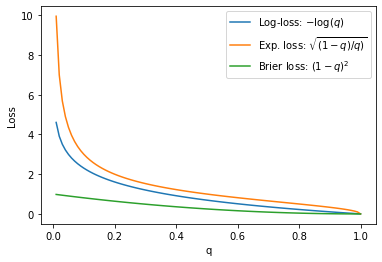

In [22]:
q = np.linspace(0.01,1,100)
plt.plot(q, -np.log(q), label='Log-loss: $-\log (q)$')
plt.plot(q, np.sqrt((1-q)/q), label='Exp. loss: $\sqrt{(1-q)/q)}$')
plt.plot(q, (1-q)**2, label='Brier loss: $(1-q)^2$')

plt.xlabel('q'); plt.ylabel('Loss')
plt.legend()
plt.show()

The behavior we see for the log-loss is that it heavily penalizes misclassified points, due to the exponential behavior - which is good - but only decreases linearly as we classify correctly - which isn't great. 

Ideally, in many applications, you would like points which are "easier to classify" (meaning that the score is close to the actual label 0 or 1) to be "taken care of" first, and then deal with points which are harder to classify. For a classification problem, these are the points close to 0.5 (assuming good model calibration). 

Notice thatm for the exponential loss, these characteristics (diverging at 0, slowly going to 0 at 1) are even more pronounced. The Brier loss has the issue that it doesn't penalize enough points with low $q$ here.

In other words, for all cases here, both misclassified and well-classified points count significantly towards the loss, with a higher contribution from misclassifications (and a particularly higher contribution in the case of log-loss and exponential loss).

### For those who have read the section on proper scoring rules:

The issue is that all losses in the Beta family have weights of the form $\omega(q) = q^{\alpha-1} (1-q)^{\beta-1}$; as we can see in the plot below, for all values of $\alpha <1$, we have the same behavior: convex curves which diverge at $q=0$ and $q=1$. Therefore, qualitatively, they all have similar behaviors as log-loss. For $\alpha=1$ (which corresponds to the Brier score), all values are equally weighted and the loss function doesn't have enough discriminative power.

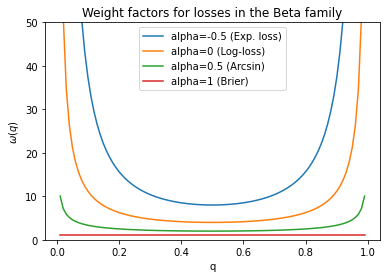

In [44]:
q = np.linspace(0.01, 0.99, 100)
for alpha, name in zip([-0.5, 0, 0.5, 1], ['Exp. loss', 'Log-loss', 'Arcsin', 'Brier']):
    plt.plot(q, (q*(1-q))**(alpha-1), label=f'alpha={alpha} ({name})')

plt.legend()
plt.ylim(0,50)
plt.xlabel("q"); plt.ylabel("$\omega(q)$"); plt.title("Weight factors for losses in the Beta family")
plt.show()

In fact, we can explicitly use the expression

$$L(y|q) = y B(1-q; \beta+1, \alpha) + (1-y) B(q; \alpha+1,\beta)$$

for the losses, and compute them explicitly. As before, take $y=1$ and study that case particularly:


In [ ]:
def incomplete_beta(x, a, b):
    from scipy.special import beta, betainc
    
    eps = 1e-6 # for numerical stability
    return beta(a+eps, b+eps) * betainc(a+eps, b+eps, x)

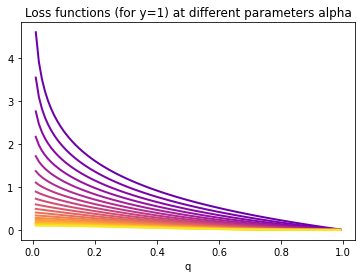

In [127]:
for a in np.arange(-0.5, 2, 0.1):
    plt.plot(q, incomplete_beta(1-q, a+1, a), c=cm.plasma((a+0.5)/2.5), linewidth=2)
plt.title("Loss functions (for y=1) at different parameters alpha")
plt.xlabel("q")
plt.show()

We can the study all these losses' behavior close to $q=1$. Taylor series are easy to calculate there, since our function $q \mapsto B(1-q;\beta+1,\alpha)$ is described as an integral of polynomial-like quantities. Hence, we should not expect eg. exponential weighings close to 1, only polynomial behavior.

In conclusion, the Beta family provides us with a class of functions which diverge at the origin $q=0$, and are polynomially behaved at $q=1$ (of course, the opposite is true if we study the loss function for $y=0$). This will affect how they perform in imbalanced cases, as we will see below.

# Losses for imbalanced classification

In the imbalanced classification case, 

## Weighting

## Focal loss

# Appendix: direct AUC maximization?

[1] Andreas Buja, Werner Stuetzle, Yi Shen (2005). *Loss Functions for Binary Class Probability Estimation and Classification: Structure and Applications*

[2] Tsung-Yi Lin, Priya Goyal, Ross Girshick, Kaiming He, Piotr Dollár. *Focal Loss for Dense Object Detection*. Available on https://arxiv.org/abs/1708.02002

In [68]:
# np.random.seed(2)
# pres_normal = 120+ 15*np.random.randn(200)
# pres_higher = 150+ 30*np.random.randn(200)

In [69]:
group_A # tomou remedio 
group_B # nao tomou

In [79]:
diferenca = group_A - 120

In [80]:
(np.abs(diferenca) < 5).mean()

0.215

In [81]:
diferenca.std()

16.20063150374675

In [82]:
diferenca.mean()

0.18375013045311334